In [1]:
import pandas as pd
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns 
import folium
from folium import Choropleth

In [2]:
# Rental History Data
one_bed_flat = pd.read_csv('../data/raw/rental_history/one_bed_flat.csv')
two_bed_flat = pd.read_csv('../data/raw/rental_history/two_bed_flat.csv')
three_bed_flat = pd.read_csv('../data/raw/rental_history/three_bed_flat.csv')
two_bed_house = pd.read_csv('../data/raw/rental_history/two_bed_house.csv')
three_bed_house = pd.read_csv('../data/raw/rental_history/three_bed_house.csv')
four_bed_house = pd.read_csv('../data/raw/rental_history/four_bed_house.csv')
all_properties = pd.read_csv('../data/raw/rental_history/all_properties.csv')

# Domain Rental Data
domain_one_bed_flat = pd.read_csv('../data/curated/domain_one_bed_flat_rent.csv')
domain_two_bed_flat = pd.read_csv('../data/curated/domain_two_bed_flat_rent.csv')
domain_three_bed_flat = pd.read_csv('../data/curated/domain_three_bed_flat_rent.csv')
domain_two_bed_house = pd.read_csv('../data/curated/domain_two_bed_house_rent.csv')
domain_three_bed_house = pd.read_csv('../data/curated/domain_three_bed_house_rent.csv')
domain_four_bed_house = pd.read_csv('../data/curated/domain_four_bed_house.csv')
domain_all_properties = pd.read_csv('../data/curated/domain_all_properties_rent.csv')

In [3]:
# Load Victoria suburbs shapefile for filtering
vic_suburbs_gdf = gpd.read_file('../data/map/Vic_Localities/gda2020_vicgrid/esrishape/whole_of_dataset/victoria/VMADMIN/LOCALITY_POLYGON.shp')
vic_suburbs_gdf = vic_suburbs_gdf.to_crs(epsg=4326)
vic_suburbs_gdf['suburb'] = vic_suburbs_gdf['GAZLOC'].str.lower()

In [4]:
# Sort by the average rent and pick the top 10 suburbs
top_10_suburbs = one_bed_flat.sort_values(by='mar_2024_median', ascending=False).head(10)

# Melt the data for these top suburbs to visualize over time
top_10_melted = top_10_suburbs.melt(id_vars=['suburb'], var_name='quarter', value_name='median_rent')

# # Plot the rental trends for top 10 suburbs
# plt.figure(figsize=(10, 6))
# sns.lineplot(data=top_10_melted, x='quarter', y='median_rent', hue='suburb')
# plt.xticks(rotation=45)
# plt.title('Top 10 Suburbs: Rental Trends Over Time')
# plt.tight_layout()
# plt.show()


In [5]:
# List of different files and their domain counterparts (replace with actual filenames)
rental_files = {'one_bed_flat': one_bed_flat, 'two_bed_flat': two_bed_flat, 'three_bed_flat': three_bed_flat, 'two_bed_house': two_bed_house,
                'three_bed_house': three_bed_house, 'four_bed_house': four_bed_house, 'all_properties': all_properties}
domain_files = {'one_bed_flat': domain_one_bed_flat, 'two_bed_flat': domain_two_bed_flat, 'three_bed_flat': domain_three_bed_flat, 'two_bed_house': domain_two_bed_house,
                'three_bed_house': domain_three_bed_house, 'four_bed_house': domain_four_bed_house, 'all_properties': domain_all_properties}

# # Iterate over each file and generate the plots
# for file_name, rental_data in rental_files.items():
    
#     # Remove 'group total'
#     rental_data = rental_data[rental_data['suburb'].str.lower() != 'group total']
    
#     # Merge with Domain data
#     domain_data = domain_files[file_name]
#     domain_data['suburb'] = domain_data['suburb'].str.lower()
#     rental_data['suburb'] = rental_data['suburb'].str.lower()
    
#     rental_data = rental_data.merge(domain_data[['suburb', 'median_rent']], on='suburb', how='left')
#     rental_data.rename(columns={'median_rent': 'sep_2024_median'}, inplace=True)
    
#     # Sort and melt data
#     top_10_suburbs = rental_data.sort_values(by='mar_2024_median', ascending=False).head(10)
#     top_10_melted = top_10_suburbs.melt(id_vars=['suburb'], var_name='quarter', value_name='median_rent')

#     # Create the plot
#     plt.figure(figsize=(10, 6))
#     sns.lineplot(data=top_10_melted, x='quarter', y='median_rent', hue='suburb')
#     plt.xticks(rotation=45)
#     plt.title(f'Top 10 Suburbs: Rental Trends Over Time for {file_name.capitalize()}')
#     plt.tight_layout()
#     plt.show()


In [6]:
# Merge the domain rental data with the GeoDataFrame
merged_gdf = vic_suburbs_gdf.merge(domain_one_bed_flat, on='suburb', how='inner')

# Drop unnecessary columns (if not needed)
merged_gdf = merged_gdf.drop(columns=['PFI_CR', 'UFI_OLD', 'UFI_CR'], errors='ignore')

# Simplify geometries for faster map rendering (optional)
merged_gdf['geometry'] = merged_gdf['geometry'].simplify(0.001)  # Adjust tolerance as needed

# Create a Folium map centered at Melbourne
m = folium.Map(location=[-37.8136, 144.9631], zoom_start=10)

# Add a Choropleth map, coloring the polygons based on the number of properties
choropleth = folium.Choropleth(
    geo_data=merged_gdf.to_json(),  # Convert to JSON format
    data=merged_gdf,  # Data containing the values to color by
    columns=['suburb', 'num_properties'],  # Columns for mapping
    key_on='feature.properties.suburb',  # Match the 'suburb' field from GeoDataFrame
    fill_color='YlOrRd',  # Color scale (can be changed)
    fill_opacity=0.6,  # Adjust the fill opacity
    line_opacity=0.4,  # Adjust the line opacity for better boundaries
    legend_name='Number of Properties'
).add_to(m)

# Add tooltips for each suburb (optional, based on median rent and num_properties)
for i, row in merged_gdf.iterrows():
    folium.GeoJson(
        row['geometry'],
        tooltip=folium.Tooltip(f"Suburb: {row['suburb'].capitalize()}<br>Median Rent: ${row['median_rent']}<br>Properties: {row['num_properties']}")
    ).add_to(m)

# Save the map to an HTML file
m.save("../plots/domain_one_bed_map.html")


In [7]:
# Merge the domain rental data with the GeoDataFrame
merged_gdf = vic_suburbs_gdf.merge(domain_four_bed_house, on='suburb', how='inner')

# Drop unnecessary columns (if not needed)
merged_gdf = merged_gdf.drop(columns=['PFI_CR', 'UFI_OLD', 'UFI_CR'], errors='ignore')

# Create a Folium map centered at Melbourne
m = folium.Map(location=[-37.8136, 144.9631], zoom_start=10)

# Add a Choropleth map, coloring the polygons based on the number of properties
choropleth = folium.Choropleth(
    geo_data=merged_gdf.to_json(),  # Convert to JSON format
    data=merged_gdf,  # Data containing the values to color by
    columns=['suburb', 'num_properties'],  # Columns for mapping
    key_on='feature.properties.suburb',  # Match the 'suburb' field from GeoDataFrame
    fill_color='YlOrRd',  # Better color scale for value distinction
    fill_opacity=0.8,  # Increase opacity for better visibility
    line_opacity=0.1,  # Thinner lines for boundaries
    line_color='gray',  # Make boundaries a neutral color
    legend_name='Number of Properties',
    highlight=True  # Enable highlighting on hover
).add_to(m)

# Add tooltips for each suburb (optional, based on median rent and num_properties)
for i, row in merged_gdf.iterrows():
    folium.GeoJson(
        row['geometry'],
        tooltip=folium.Tooltip(f"Suburb: {row['suburb'].capitalize()}<br>Median Rent: ${row['median_rent']}<br>Properties: {row['num_properties']}")
    ).add_to(m)

# Save the map to an HTML file
m.save("../plots/domain_four_bed_house_map.html")

# To display the map in the notebook (optional)
# m


In [25]:
# Revert to the original vibrant color scheme
property_colors = {
    'one_bed_flat': '#F82B35',  
    'two_bed_flat': '#F82B9C',  
    'three_bed_flat': '#ED2BF8',  
    'two_bed_house': '#872BF8',  
    'three_bed_house': '#2B36F8',  
    'four_bed_house': '#2B9CF8'  
}

# Adjust the styling: keep strong boundaries and bright colors
highlighted_style_template = {
    'fillOpacity': 0.6,  # Higher opacity for more vibrant colors
    'color': 'black',  # Strong black borders
    'weight': 1.0  # Clear boundary lines
}

# Create the folium map centered at Melbourne using the default tileset (OpenStreetMap)
m = folium.Map(location=[-37.8136, 144.9631], zoom_start=10)

# Iterate through each property type and add the corresponding GeoJson layer with vibrant colors
for property_type, color in property_colors.items():
    highlighted_style = highlighted_style_template.copy()
    highlighted_style['fillColor'] = color

    merged_gdf = vic_suburbs_gdf.merge(domain_files[property_type], on='suburb', how='inner')
    merged_gdf = merged_gdf.drop(columns=['PFI_CR', 'UFI_OLD', 'UFI_CR'], errors='ignore')
    top_10_suburbs = merged_gdf.sort_values(by='num_properties', ascending=False).head(10)
    
    # Add GeoJson to the map with custom color and tooltip
    for i, row in top_10_suburbs.iterrows():
        folium.GeoJson(
            row['geometry'],
            style_function=lambda x, color=color: {
                'fillColor': color,
                'color': 'black',  # Strong black borders
                'fillOpacity': 0.6,  # Higher opacity for vibrant colors
                'weight': 1.0  # Clear boundary lines
            },
            tooltip=folium.Tooltip(f"Suburb: {row['suburb'].capitalize()}<br>Median Rent: ${row['median_rent']}<br>Properties: {row['num_properties']}")
        ).add_to(m)

# Custom legend with the vibrant colors and larger blocks
legend_html = '''
<div style="position: fixed;
     bottom: 30px; left: 30px; width: 200px; height: 280px;
     background-color: white; border:2px solid grey; z-index:9999; font-size:16px;
     ">&nbsp; <b>Property Type Legend</b><br>
     &nbsp; <i style="color:#F82B35; font-size:20px;">■</i>&nbsp; One-bed Flat<br>
     &nbsp; <i style="color:#F82B9C; font-size:20px;">■</i>&nbsp; Two-bed Flat<br>
     &nbsp; <i style="color:#ED2BF8; font-size:20px;">■</i>&nbsp; Three-bed Flat<br>
     &nbsp; <i style="color:#872BF8; font-size:20px;">■</i>&nbsp; Two-bed House<br>
     &nbsp; <i style="color:#2B36F8; font-size:20px;">■</i>&nbsp; Three-bed House<br>
     &nbsp; <i style="color:#2B9CF8; font-size:20px;">■</i>&nbsp; Four-bed House<br>
</div>
'''

# Add the larger legend to the map
m.get_root().html.add_child(folium.Element(legend_html))

# Save the map with the original colors and enhanced legend
m.save("../plots/domain_top_10_property_types_map.html")


In [9]:
properties = pd.read_csv("../data/raw/properties.csv")

In [10]:
properties

,suburb,postcode,property_type,weekly_rent,bond,num_bed,num_bath,num_parkings,furnished,pets_allowed,coordinates
0,melbourne,3000,Apartment,530.0,2303.0,1,1,1,False,False,"-37.8102191,144.966267"
1,melbourne,3000,Apartment,500.0,2173.0,1,1,0,False,False,"-37.810779,144.9685513"
2,melbourne,3000,Apartment,470.0,2042.0,1,1,0,False,False,"-37.81441450000001,144.9539107"
3,melbourne,3000,Apartment,400.0,1738.0,1,1,0,True,False,"-37.8175167,144.9664983"
4,melbourne,3000,Apartment,520.0,2260.0,2,1,0,True,False,"-37.8099061,144.9711071"
...,...,...,...,...,...,...,...,...,...,...,...
13615,sunset strip,3922,House,800.0,3476.0,4,2,0,True,False,"-38.4959115,145.2640573"
13616,rosebud,3939,House,700.0,3042.0,4,3,2,False,False,"-38.3579258,144.9109711"
13617,cranbourne,3977,House,510.0,2216.0,3,1,6,False,False,"-38.0920656,145.2781526"
13618,cranbourne,3977,House,240.0,960.0,1,1,0,False,False,"-38.1019484,145.2876772"


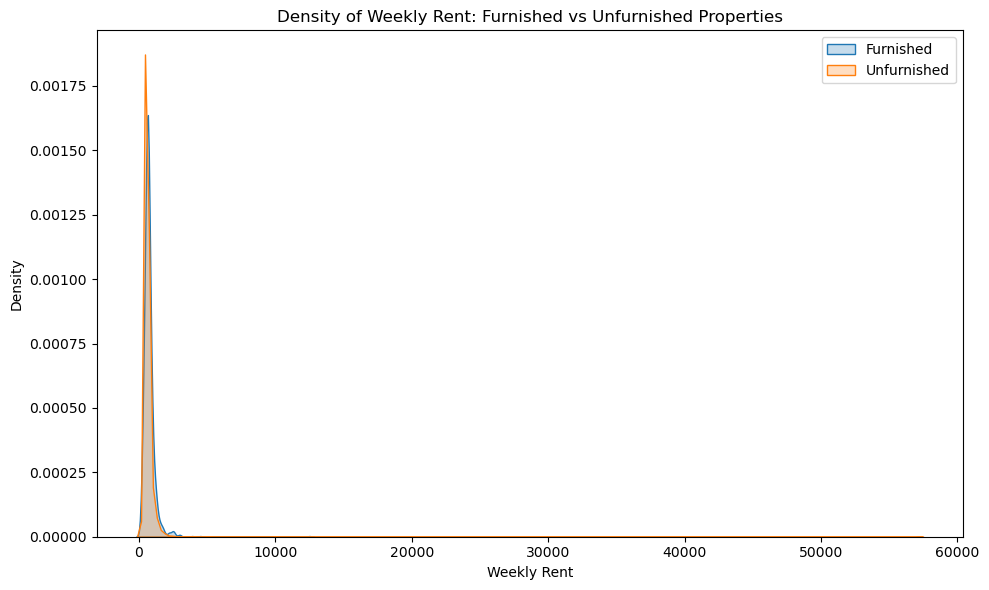

In [11]:
# plt.figure(figsize=(10, 6))

# # Plot the KDE for both furnished and unfurnished properties
# sns.kdeplot(data=properties[properties['furnished'] == True], x='weekly_rent', label='Furnished', fill=True)
# sns.kdeplot(data=properties[properties['furnished'] == False], x='weekly_rent', label='Unfurnished', fill=True)

# # Add labels and title
# plt.title('Density of Weekly Rent: Furnished vs Unfurnished Properties')
# plt.xlabel('Weekly Rent')
# plt.ylabel('Density')

# # Show legend and plot
# plt.legend()
# plt.tight_layout()
# plt.show()


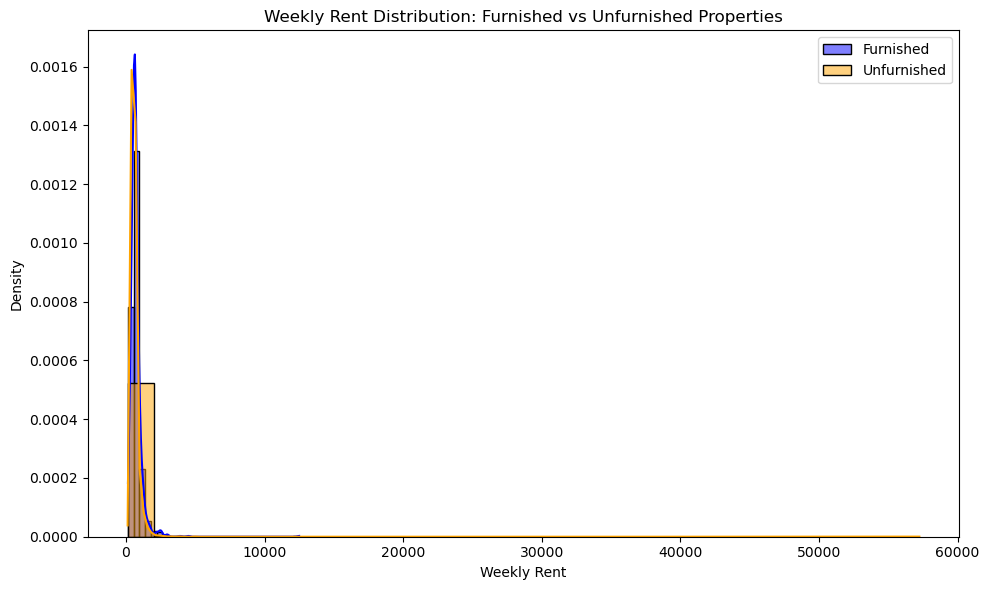

In [12]:
# plt.figure(figsize=(10, 6))

# # Plot histogram for furnished properties
# sns.histplot(properties[properties['furnished'] == True]['weekly_rent'], label='Furnished', color='blue', kde=True, bins=30, stat="density", fill=True)

# # Plot histogram for unfurnished properties
# sns.histplot(properties[properties['furnished'] == False]['weekly_rent'], label='Unfurnished', color='orange', kde=True, bins=30, stat="density", fill=True)

# # Add labels and title
# plt.title('Weekly Rent Distribution: Furnished vs Unfurnished Properties')
# plt.xlabel('Weekly Rent')
# plt.ylabel('Density')

# # Show legend and plot
# plt.legend()
# plt.tight_layout()
# plt.show()


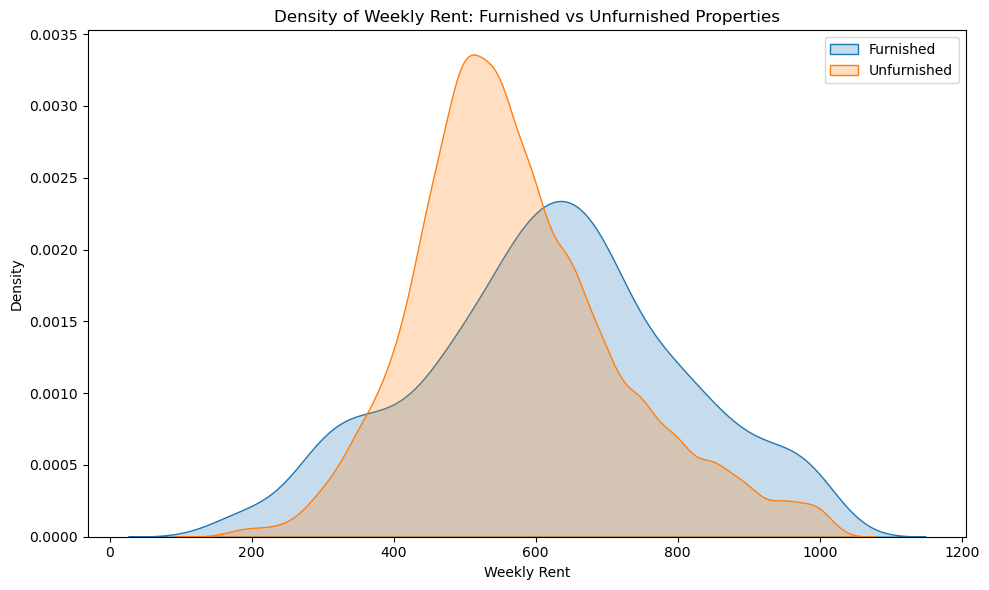

In [26]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = properties['weekly_rent'].quantile(0.25)
Q3 = properties['weekly_rent'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Define lower and upper bound for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the data
filtered_properties = properties[(properties['weekly_rent'] >= lower_bound) & (properties['weekly_rent'] <= upper_bound)]

# Now plot using the cleaned dataset
plt.figure(figsize=(10, 6))

# Plot the KDE for both furnished and unfurnished properties
sns.kdeplot(data=filtered_properties[filtered_properties['furnished'] == True], x='weekly_rent', label='Furnished', fill=True)
sns.kdeplot(data=filtered_properties[filtered_properties['furnished'] == False], x='weekly_rent', label='Unfurnished', fill=True)

# Add labels and title
plt.title('Density of Weekly Rent: Furnished vs Unfurnished Properties')
plt.xlabel('Weekly Rent')
plt.ylabel('Density')

# Show legend and plot
plt.legend()
plt.tight_layout()
plt.savefig("../plots/un-furnished_density.png")
plt.show()


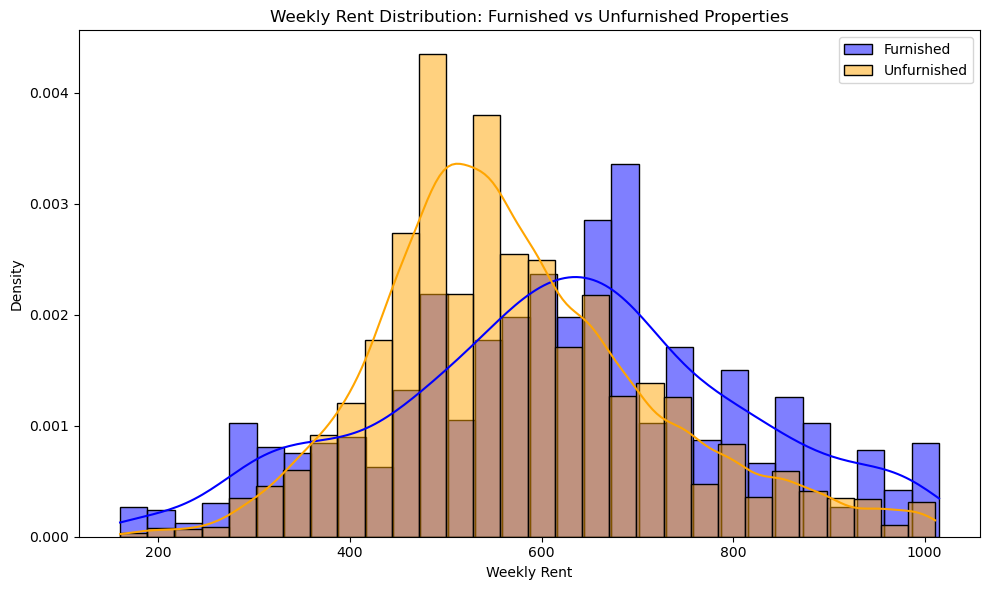

In [14]:
# plt.figure(figsize=(10, 6))

# # Plot histogram for furnished properties
# sns.histplot(filtered_properties[filtered_properties['furnished'] == True]['weekly_rent'], label='Furnished', color='blue', kde=True, bins=30, stat="density", fill=True)

# # Plot histogram for unfurnished properties
# sns.histplot(filtered_properties[filtered_properties['furnished'] == False]['weekly_rent'], label='Unfurnished', color='orange', kde=True, bins=30, stat="density", fill=True)

# # Add labels and title
# plt.title('Weekly Rent Distribution: Furnished vs Unfurnished Properties')
# plt.xlabel('Weekly Rent')
# plt.ylabel('Density')

# # Show legend and plot
# plt.legend()
# plt.tight_layout()
# plt.show()


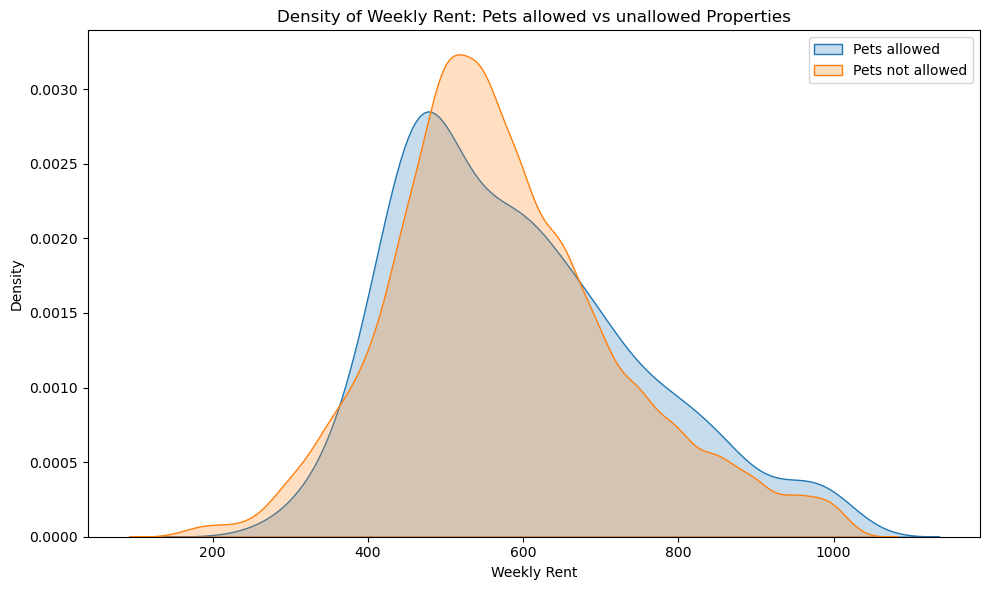

In [15]:
# # Now plot using the cleaned dataset
# plt.figure(figsize=(10, 6))

# # Plot the KDE for both furnished and unfurnished properties
# sns.kdeplot(data=filtered_properties[filtered_properties['pets_allowed'] == True], x='weekly_rent', label='Pets allowed', fill=True)
# sns.kdeplot(data=filtered_properties[filtered_properties['pets_allowed'] == False], x='weekly_rent', label='Pets not allowed', fill=True)

# # Add labels and title
# plt.title('Density of Weekly Rent: Pets allowed vs unallowed Properties')
# plt.xlabel('Weekly Rent')
# plt.ylabel('Density')

# # Show legend and plot
# plt.legend()
# plt.tight_layout()
# plt.show()

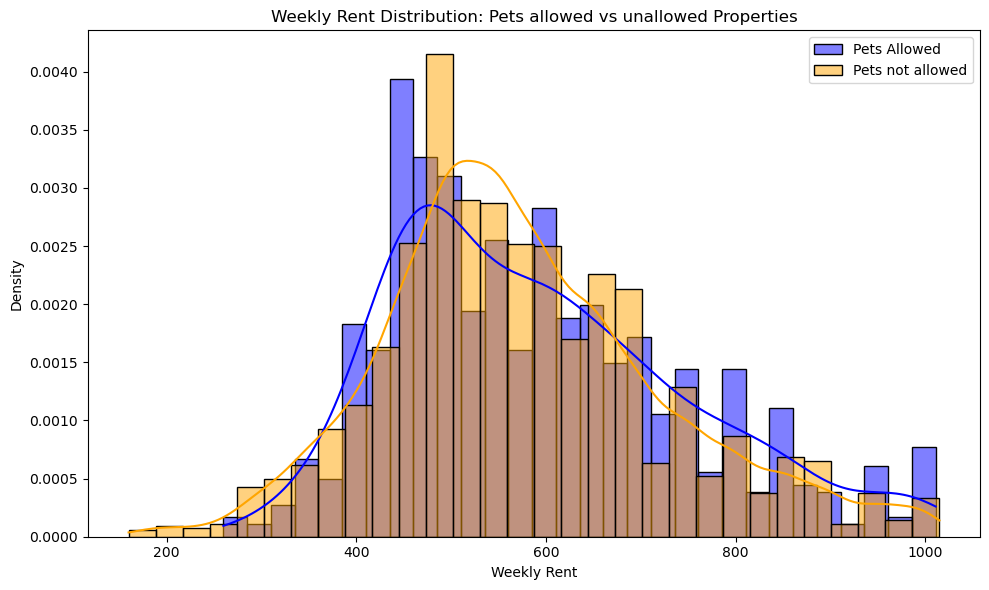

In [16]:
# plt.figure(figsize=(10, 6))

# # Plot histogram for furnished properties
# sns.histplot(filtered_properties[filtered_properties['pets_allowed'] == True]['weekly_rent'], label='Pets Allowed', color='blue', kde=True, bins=30, stat="density", fill=True)

# # Plot histogram for unfurnished properties
# sns.histplot(filtered_properties[filtered_properties['pets_allowed'] == False]['weekly_rent'], label='Pets not allowed', color='orange', kde=True, bins=30, stat="density", fill=True)

# # Add labels and title
# plt.title('Weekly Rent Distribution: Pets allowed vs unallowed Properties')
# plt.xlabel('Weekly Rent')
# plt.ylabel('Density')

# # Show legend and plot
# plt.legend()
# plt.tight_layout()
# plt.show()


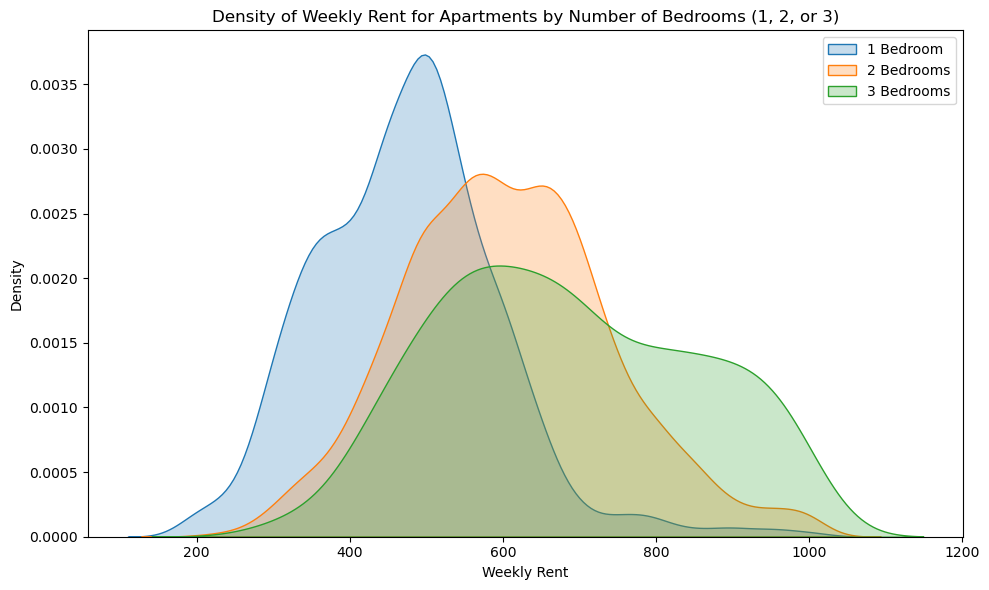

In [27]:
# Step 1: Filter the data for properties where property_type is "Apartment" and num_bed is 1, 2, or 3
apartment_properties = properties[(properties['property_type'] == 'Apartment') & (properties['num_bed'].isin([1, 2, 3]))]

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = properties['weekly_rent'].quantile(0.25)
Q3 = properties['weekly_rent'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Define lower and upper bound for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the data
apartment_properties = apartment_properties[(apartment_properties['weekly_rent'] >= lower_bound) & (apartment_properties['weekly_rent'] <= upper_bound)]

# Step 2: Plot the KDE for weekly rent for apartments with 1, 2, or 3 bedrooms
plt.figure(figsize=(10, 6))

# KDE plot for 1-bedroom apartments
sns.kdeplot(data=apartment_properties[apartment_properties['num_bed'] == 1], x='weekly_rent', label='1 Bedroom', fill=True)

# KDE plot for 2-bedroom apartments
sns.kdeplot(data=apartment_properties[apartment_properties['num_bed'] == 2], x='weekly_rent', label='2 Bedrooms', fill=True)

# KDE plot for 3-bedroom apartments
sns.kdeplot(data=apartment_properties[apartment_properties['num_bed'] == 3], x='weekly_rent', label='3 Bedrooms', fill=True)

# Add labels and title
plt.title('Density of Weekly Rent for Apartments by Number of Bedrooms (1, 2, or 3)')
plt.xlabel('Weekly Rent')
plt.ylabel('Density')

# Show legend and plot
plt.legend()
plt.tight_layout()
plt.show()

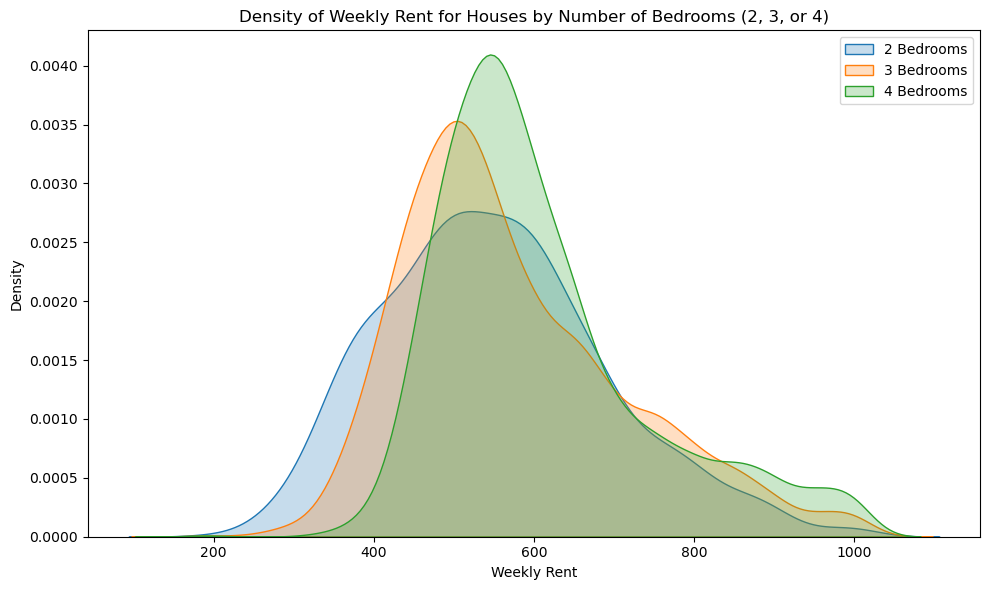

In [28]:
# Step 1: Filter the data for properties where property_type is "house" and num_bed is 2,3,4
house_properties = properties[(properties['property_type'] == 'House') & (properties['num_bed'].isin([2, 3, 4]))]

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = properties['weekly_rent'].quantile(0.25)
Q3 = properties['weekly_rent'].quantile(0.75)

# Calculate the IQR
IQR = Q3 - Q1

# Define lower and upper bound for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers from the data
house_properties = house_properties[(house_properties['weekly_rent'] >= lower_bound) & (house_properties['weekly_rent'] <= upper_bound)]

# Step 2: Plot the KDE for weekly rent for houses with 1, 2, or 3 bedrooms
plt.figure(figsize=(10, 6))

# KDE plot for 1-bedroom houses
sns.kdeplot(data=house_properties[house_properties['num_bed'] == 2], x='weekly_rent', label='2 Bedrooms', fill=True)

# KDE plot for 2-bedroom houses
sns.kdeplot(data=house_properties[house_properties['num_bed'] == 3], x='weekly_rent', label='3 Bedrooms', fill=True)

# KDE plot for 3-bedroom houses
sns.kdeplot(data=house_properties[house_properties['num_bed'] == 4], x='weekly_rent', label='4 Bedrooms', fill=True)

# Add labels and title
plt.title('Density of Weekly Rent for Houses by Number of Bedrooms (2, 3, or 4)')
plt.xlabel('Weekly Rent')
plt.ylabel('Density')

# Show legend and plot
plt.legend()
plt.tight_layout()
plt.show()

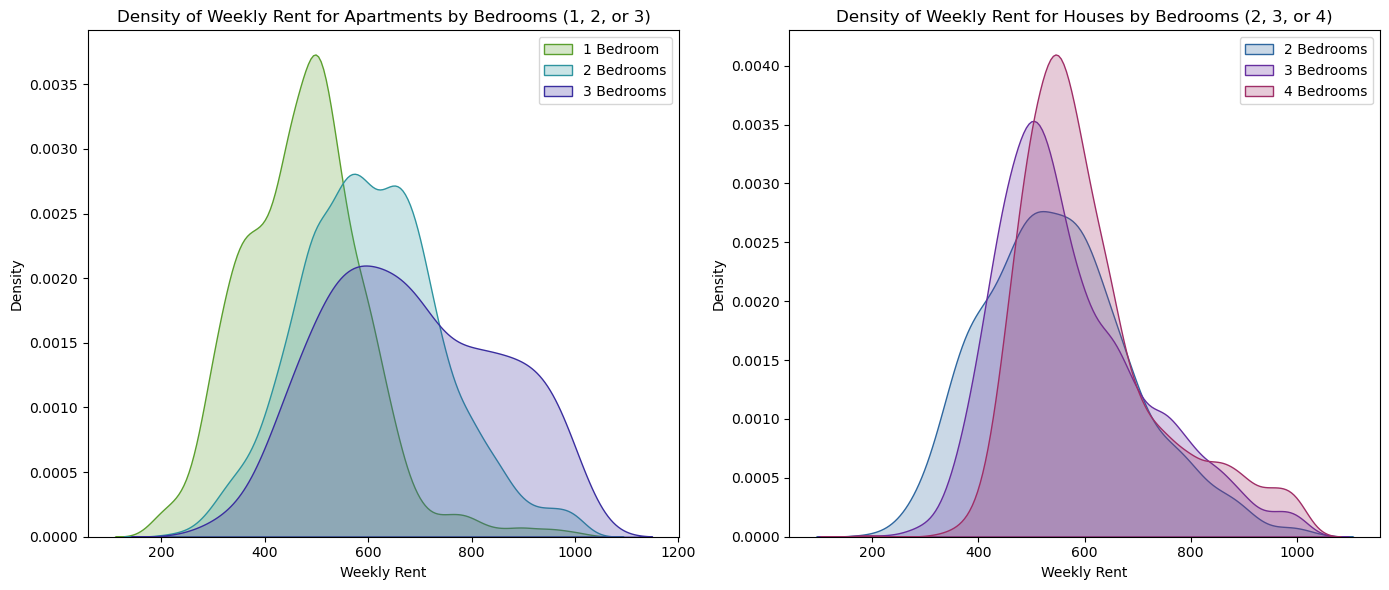

In [32]:
# Define custom colors for the KDE plots that align with the blue-themed presentation
apartment_colors = ['#5B9F2E', '#2E949F', '#3A2E9F']  # Blue palette with an accent orange
house_colors = ['#2E679F', '#662E9F', '#9F2E67']  # Green palette with an accent red

# Step 1: Create subplots for apartment and house KDE plots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: Apartments
sns.kdeplot(data=apartment_properties[apartment_properties['num_bed'] == 1], x='weekly_rent', label='1 Bedroom', fill=True, ax=axes[0], color=apartment_colors[0])
sns.kdeplot(data=apartment_properties[apartment_properties['num_bed'] == 2], x='weekly_rent', label='2 Bedrooms', fill=True, ax=axes[0], color=apartment_colors[1])
sns.kdeplot(data=apartment_properties[apartment_properties['num_bed'] == 3], x='weekly_rent', label='3 Bedrooms', fill=True, ax=axes[0], color=apartment_colors[2])
axes[0].set_title('Density of Weekly Rent for Apartments by Bedrooms (1, 2, or 3)')
axes[0].set_xlabel('Weekly Rent')
axes[0].set_ylabel('Density')
axes[0].legend()

# Second subplot: Houses
sns.kdeplot(data=house_properties[house_properties['num_bed'] == 2], x='weekly_rent', label='2 Bedrooms', fill=True, ax=axes[1], color=house_colors[0])
sns.kdeplot(data=house_properties[house_properties['num_bed'] == 3], x='weekly_rent', label='3 Bedrooms', fill=True, ax=axes[1], color=house_colors[1])
sns.kdeplot(data=house_properties[house_properties['num_bed'] == 4], x='weekly_rent', label='4 Bedrooms', fill=True, ax=axes[1], color=house_colors[2])
axes[1].set_title('Density of Weekly Rent for Houses by Bedrooms (2, 3, or 4)')
axes[1].set_xlabel('Weekly Rent')
axes[1].set_ylabel('Density')
axes[1].legend()

# Adjust layout for better visual spacing
plt.tight_layout()

# Display the plots side by side
plt.savefig("../plots/weekly_rent_distribution.png")
plt.show()


- plot lines for the least expensive and the most expensive
- create one map that combines the frequency of each type of graph

In [33]:
# Step 1: Remove the "group total" if necessary (as you mentioned earlier)
two_bed_flat = two_bed_flat[two_bed_flat['suburb'].str.lower() != 'group total']

# Step 2: Identify top 7 and bottom 7 suburbs based on the most recent median rent (e.g., 'mar_2024_median')
top_7_expensive = two_bed_flat.sort_values(by='mar_2024_median', ascending=False).head(7)
bottom_7_cheap = two_bed_flat.sort_values(by='mar_2024_median', ascending=True).head(7)

# Step 3: Melt the data for plotting trends over time (pivot the dataframe from wide to long format)
top_7_melted = top_7_expensive.melt(id_vars=['suburb'], var_name='quarter', value_name='median_rent')
bottom_7_melted = bottom_7_cheap.melt(id_vars=['suburb'], var_name='quarter', value_name='median_rent')

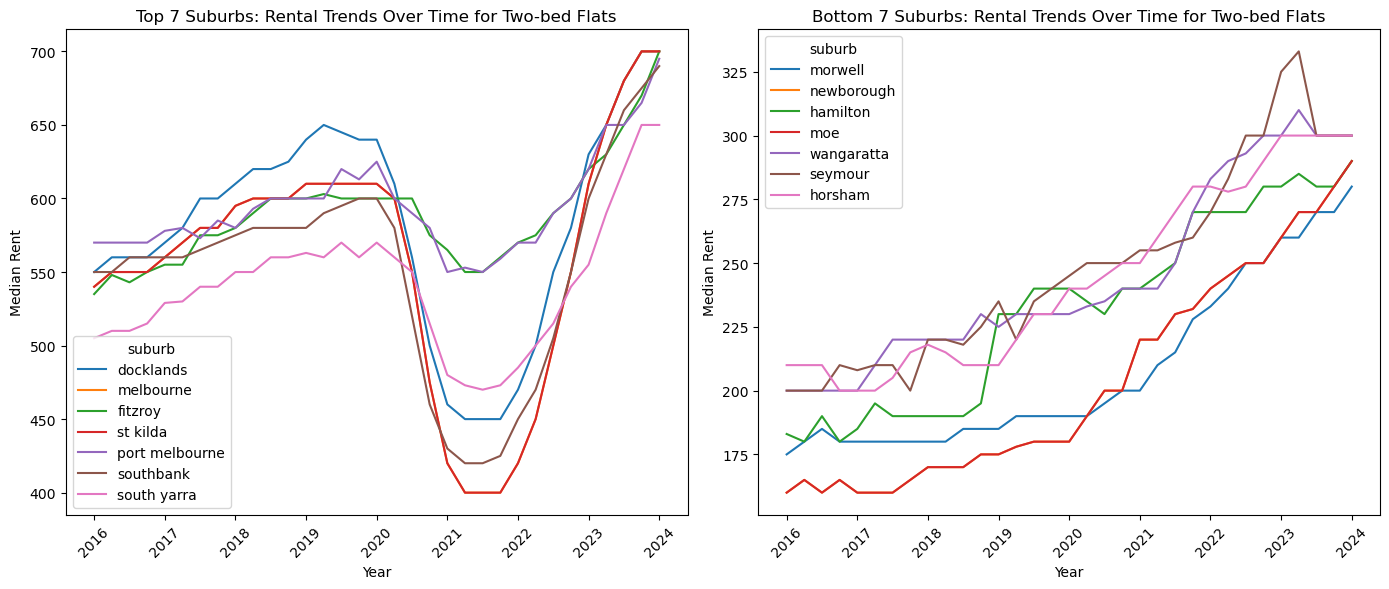

In [34]:
# Step 1: Create a figure with subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plot for Top 10 Most Expensive Suburbs (on the first subplot)
sns.lineplot(data=top_7_melted, x='quarter', y='median_rent', hue='suburb', ax=axes[0])
axes[0].set_title('Top 7 Suburbs: Rental Trends Over Time for Two-bed Flats')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Median Rent')

# Plot for Bottom 10 Least Expensive Suburbs (on the second subplot)
sns.lineplot(data=bottom_7_melted, x='quarter', y='median_rent', hue='suburb', ax=axes[1])
axes[1].set_title('Bottom 7 Suburbs: Rental Trends Over Time for Two-bed Flats')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Median Rent')

# Step 2: Manually extract the year from the 'quarter' strings (like 'mar_2016_median')
for ax in axes:
    # Get the current x-tick labels and extract the year from each label
    xticks_labels = [label.get_text() for label in ax.get_xticklabels()]
    years = [label.split('_')[1] for label in xticks_labels]  # Extract the year part

    # Update the x-tick labels with the extracted years
    ax.set_xticks(ax.get_xticks()[::4])  # Show every 4th tick to reduce clutter (adjust as needed)
    ax.set_xticklabels(years[::4])  # Apply only the years as labels

# Step 3: Adjust layout and remove overlap
plt.tight_layout()
plt.savefig("../plots/2bflat_comparison.png")
plt.show()

In [35]:
# Step 1: Remove the "group total" if necessary (as you mentioned earlier)
two_bed_house = two_bed_house[two_bed_house['suburb'].str.lower() != 'group total']

# Step 2: Identify top 7 and bottom 7 suburbs based on the most recent median rent (e.g., 'mar_2024_median')
top_7_expensive = two_bed_house.sort_values(by='mar_2024_median', ascending=False).head(7)
bottom_7_cheap = two_bed_house.sort_values(by='mar_2024_median', ascending=True).head(7)

# Step 3: Melt the data for plotting trends over time (pivot the dataframe from wide to long format)
top_7_melted = top_7_expensive.melt(id_vars=['suburb'], var_name='quarter', value_name='median_rent')
bottom_7_melted = bottom_7_cheap.melt(id_vars=['suburb'], var_name='quarter', value_name='median_rent')

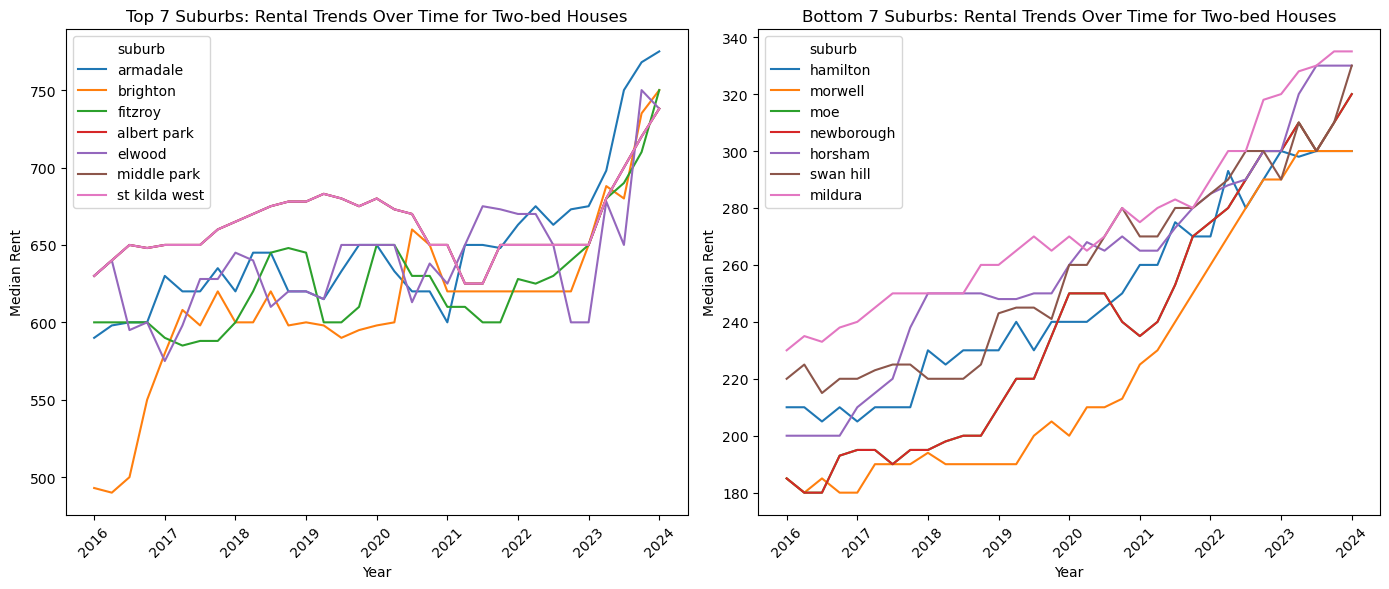

In [36]:
# Step 1: Create a figure with subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plot for Top 10 Most Expensive Suburbs (on the first subplot)
sns.lineplot(data=top_7_melted, x='quarter', y='median_rent', hue='suburb', ax=axes[0])
axes[0].set_title('Top 7 Suburbs: Rental Trends Over Time for Two-bed Houses')
axes[0].tick_params(axis='x', rotation=45)
axes[0].set_xlabel('Year')
axes[0].set_ylabel('Median Rent')

# Plot for Bottom 10 Least Expensive Suburbs (on the second subplot)
sns.lineplot(data=bottom_7_melted, x='quarter', y='median_rent', hue='suburb', ax=axes[1])
axes[1].set_title('Bottom 7 Suburbs: Rental Trends Over Time for Two-bed Houses')
axes[1].tick_params(axis='x', rotation=45)
axes[1].set_xlabel('Year')
axes[1].set_ylabel('Median Rent')

# Step 2: Manually extract the year from the 'quarter' strings (like 'mar_2016_median')
for ax in axes:
    # Get the current x-tick labels and extract the year from each label
    xticks_labels = [label.get_text() for label in ax.get_xticklabels()]
    years = [label.split('_')[1] for label in xticks_labels]  # Extract the year part

    # Update the x-tick labels with the extracted years
    ax.set_xticks(ax.get_xticks()[::4])  # Show every 4th tick to reduce clutter (adjust as needed)
    ax.set_xticklabels(years[::4])  # Apply only the years as labels

# Step 3: Adjust layout and remove overlap
plt.tight_layout()
plt.savefig("../plots/2bhouse_comparison.png")
plt.show()